In [15]:
import torch
import torchvision
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torchvision.transforms as transforms
import os
import xml.etree.ElementTree as ET
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time
from tqdm import tqdm 
import math
import coremltools as ct
import pandas as pd

In [27]:
IMAGE_PATH = 'images'
XML_PATH = 'annotations'

# filtering due to some jupyter notebook metafiles causing havoc
images = list(sorted(filter(lambda x: os.path.splitext(x)[1] == '.png', os.listdir(IMAGE_PATH))))
xmls = list(sorted(filter(lambda x: os.path.splitext(x)[1] == '.xml', os.listdir(XML_PATH))))

images_train = images[:753]
xmls_train = xmls[:753]

images_test = images[753:]
xmls_test = xmls[753:]

In [28]:
def parse_annot(xml):
    bbox = []
    labels = []
    
    label_map = {
        'without_mask': 1,
        'with_mask': 2,
        'mask_weared_incorrect': 3 
    }
    
    tree = ET.parse(xml)
    root = tree.getroot()
    
    for box in root.iter('object'):
        bbox.append(
               [
                   int(box.find('bndbox/xmin').text),
                   int(box.find('bndbox/ymin').text),
                   int(box.find('bndbox/xmax').text),
                   int(box.find('bndbox/ymax').text),
               ]
        )
        labels.append(
            label_map[box.find('name').text]
        )
    
    return bbox, labels

def draw_boxes(img, bbox, labels):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    
    color_label = {
        1: (255, 0, 0),
        2: (0, 255, 0),
        3: (0, 0, 255)
    }
    
    for (x, y, w, h), label in zip(bbox, labels):
        x, y, w, h = [int(n) for n in [x, y, w, h]]
        cv2.rectangle(img, (x,y), (w,h), color_label[label], 1)
        
    return cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    

In [29]:
class ImageDataset(Dataset):
    def __init__(self, img_dir, xml_dir, img_files, xml_files):
        self.img_dir = img_dir
        self.xml_dir = xml_dir
        self.img_files = img_files
        self.xml_files = xml_files

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        image = cv2.imread(os.path.join(self.img_dir, self.img_files[idx]))
        image = transforms.ToTensor()(image)
        
        bbox, labels = parse_annot(os.path.join(self.xml_dir, self.xml_files[idx]))
        
        boxes = torch.as_tensor(bbox, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        
        target = {
            'boxes': boxes,
            'labels': labels
        }
        
        return image, target

In [36]:
mask_dataset = ImageDataset(IMAGE_PATH, XML_PATH, images_train, xmls_train)

def collate_fn(batch):
    return tuple(zip(*batch))

data_loader = torch.utils.data.DataLoader(
    mask_dataset,
    batch_size=4,
    collate_fn=collate_fn
)

In [31]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [32]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, 4)

In [33]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.01,momentum=0.9, weight_decay=0.0005)

In [34]:
def train_one_epoch(model, optimizer, loader, device, epoch):
    model.to(device)
    model.train()
    
    all_losses = []
    all_losses_dict = []
    
    for images, targets in tqdm(loader):
        images = list(image.to(device) for image in images)
        targets = [{k: torch.tensor(v).to(device) for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        loss_dict_append = {k: v.item() for k, v in loss_dict.items()}
        loss_value = losses.item()
        all_losses.append(loss_value)
        all_losses_dict.append(loss_dict_append)
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
    all_losses_dict = pd.DataFrame(all_losses_dict) # for printing
    print("Epoch {}, lr: {:.6f}, loss: {:.6f}, loss_classifier: {:.6f}, loss_box: {:.6f}, loss_rpn_box: {:.6f}, loss_object: {:.6f}".format(
        epoch, optimizer.param_groups[0]['lr'], np.mean(all_losses),
        all_losses_dict['loss_classifier'].mean(),
        all_losses_dict['loss_box_reg'].mean(),
        all_losses_dict['loss_rpn_box_reg'].mean(),
        all_losses_dict['loss_objectness'].mean()
    ))

In [37]:
import warnings
warnings.filterwarnings("ignore")

num_epochs=10

for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, data_loader, device, epoch)

100%|██████████| 189/189 [04:49<00:00,  1.53s/it]


Epoch 0, lr: 0.010000, loss: 0.431110, loss_classifier: 0.164375, loss_box: 0.230544, loss_rpn_box: 0.013796, loss_object: 0.022395


100%|██████████| 189/189 [04:55<00:00,  1.57s/it]


Epoch 1, lr: 0.010000, loss: 0.289993, loss_classifier: 0.098589, loss_box: 0.176126, loss_rpn_box: 0.009098, loss_object: 0.006181


100%|██████████| 189/189 [04:55<00:00,  1.56s/it]


Epoch 2, lr: 0.010000, loss: 0.242390, loss_classifier: 0.080467, loss_box: 0.151248, loss_rpn_box: 0.007398, loss_object: 0.003276


100%|██████████| 189/189 [04:56<00:00,  1.57s/it]


Epoch 3, lr: 0.010000, loss: 0.214740, loss_classifier: 0.068600, loss_box: 0.136738, loss_rpn_box: 0.006676, loss_object: 0.002726


100%|██████████| 189/189 [04:55<00:00,  1.56s/it]


Epoch 4, lr: 0.010000, loss: 0.197099, loss_classifier: 0.062817, loss_box: 0.125125, loss_rpn_box: 0.005987, loss_object: 0.003170


100%|██████████| 189/189 [04:55<00:00,  1.57s/it]


Epoch 5, lr: 0.010000, loss: 0.188762, loss_classifier: 0.054747, loss_box: 0.125400, loss_rpn_box: 0.006173, loss_object: 0.002442


100%|██████████| 189/189 [04:55<00:00,  1.57s/it]


Epoch 6, lr: 0.010000, loss: 0.174448, loss_classifier: 0.048346, loss_box: 0.119232, loss_rpn_box: 0.005215, loss_object: 0.001655


100%|██████████| 189/189 [04:56<00:00,  1.57s/it]


Epoch 7, lr: 0.010000, loss: 0.163942, loss_classifier: 0.044356, loss_box: 0.113211, loss_rpn_box: 0.004877, loss_object: 0.001498


100%|██████████| 189/189 [04:56<00:00,  1.57s/it]


Epoch 8, lr: 0.010000, loss: 0.149370, loss_classifier: 0.040287, loss_box: 0.102966, loss_rpn_box: 0.004730, loss_object: 0.001387


100%|██████████| 189/189 [04:56<00:00,  1.57s/it]

Epoch 9, lr: 0.010000, loss: 0.147162, loss_classifier: 0.038207, loss_box: 0.102222, loss_rpn_box: 0.005403, loss_object: 0.001331


In [38]:
torch.save(model.state_dict(),'./masknet_10_epochs.pth')

In [58]:
def rcnn_predict_img(img, nm_thrs=0.3, score_thrs=0.8):
    img = transforms.ToTensor()(img)
    img = img.to("cuda")
    model.eval()
    
    with torch.no_grad():
        predictions = model(img.unsqueeze(0))
        
    # non-max supression
    keep_boxes = torchvision.ops.nms(predictions[0]['boxes'].cpu(), predictions[0]['scores'].cpu(), nm_thrs)
    
    # Only display the bounding boxes which higher than the threshold
    score_filter = predictions[0]['scores'].cpu().numpy()[keep_boxes] > score_thrs
    
    # get the filtered result
    test_boxes = predictions[0]['boxes'].cpu().numpy()[keep_boxes][score_filter]
    test_labels = predictions[0]['labels'].cpu().numpy()[keep_boxes][score_filter]
    
    return test_boxes, test_labels

In [56]:
checkpoint = torch.load('./masknet_10_epochs.pth', map_location=device)
model.load_state_dict(checkpoint)
if torch.cuda.is_available():
    model.cuda()

maksssksksss777.png
[[136.61067   40.37211  164.5732    73.6186  ]
 [285.35626   34.057693 322.10608   71.85845 ]
 [361.16843   30.59152  397.41324   73.28657 ]
 [ 25.995491  74.01135   68.20158  122.14233 ]
 [188.2563    49.826466 221.43427   87.82759 ]
 [ 72.528854  45.09247  101.857285  78.44843 ]
 [ 49.30191  142.96944  107.57775  201.20863 ]
 [226.33852   46.768574 248.8164    69.43297 ]]
[2 2 2 2 2 2 2 1]
Annotation boxes
[49, 146, 102, 201]
[26, 82, 70, 122]
[73, 48, 102, 78]
[137, 42, 163, 74]
[187, 52, 220, 86]
[226, 47, 248, 70]
[285, 35, 322, 71]
[363, 32, 397, 72]
Annotation labels
[2, 2, 2, 2, 2, 1, 2, 2]


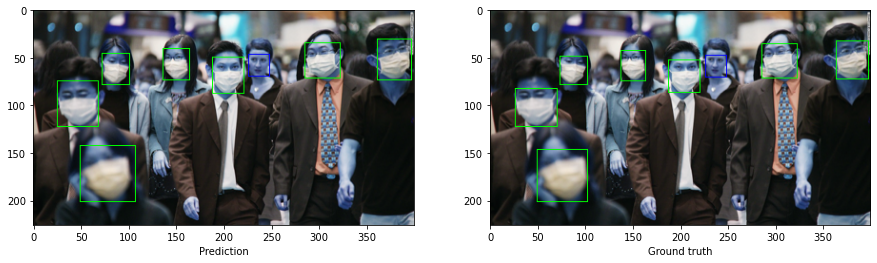

In [65]:
print(images_test[0])
test_img = cv2.imread(os.path.join(IMAGE_PATH, images_test[0]))

boxes, labels = rcnn_predict_img(test_img)

print(boxes)
print(labels)

img1 = draw_boxes(test_img, boxes, labels)

boxes, labels = parse_annot(os.path.join(XML_PATH, xmls_test[0]))
img2 = draw_boxes(test_img, boxes, labels)

print("Annotation boxes")
for box in boxes:
    print(box)

print("Annotation labels")
print(labels)
    
# Display the result
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
ax1.imshow(img1)
ax1.set_xlabel('Prediction')
ax2.imshow(img2)
ax2.set_xlabel('Ground truth')
plt.show()

In [3]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, 4)

checkpoint = torch.load('./masknet-20e.pth', map_location=device)
model.load_state_dict(checkpoint)

<All keys matched successfully>

In [6]:
cv2.namedWindow("preview")
vc = cv2.VideoCapture(0)

if vc.isOpened(): # try to get the first frame
    rval, frame = vc.read()
else:
    rval = False

cv2.startWindowThread()

while rval:
    boxes, labels = rcnn_predict_img(frame)
    frame = draw_boxes(frame, boxes, labels)
    cv2.imshow("preview", frame)
    rval, frame = vc.read()
    key = cv2.waitKey(20)
    if key == 27: # exit on ESC
        break

vc.release()
cv2.destroyAllWindows()
for i in range (1, 5): # hack to get openCV2 to close the window
    cv2.waitKey(1)

KeyboardInterrupt: 